In [1]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 
from matplotlib.patches import Patch
#### PLOT THE DATA #######
SMALL_SIZE = 13.5
MEDIUM_SIZE = 17
BIGGER_SIZE = 23
plt.rcParams["font.family"] = "serif"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


index 0
index 1
index 2
index 3
index 4
index 5
index 6
index 7
index 8
index 9
index 10
index 11
index 12
index 13
index 14
index 15
index 16
index 17
index 18
index 19


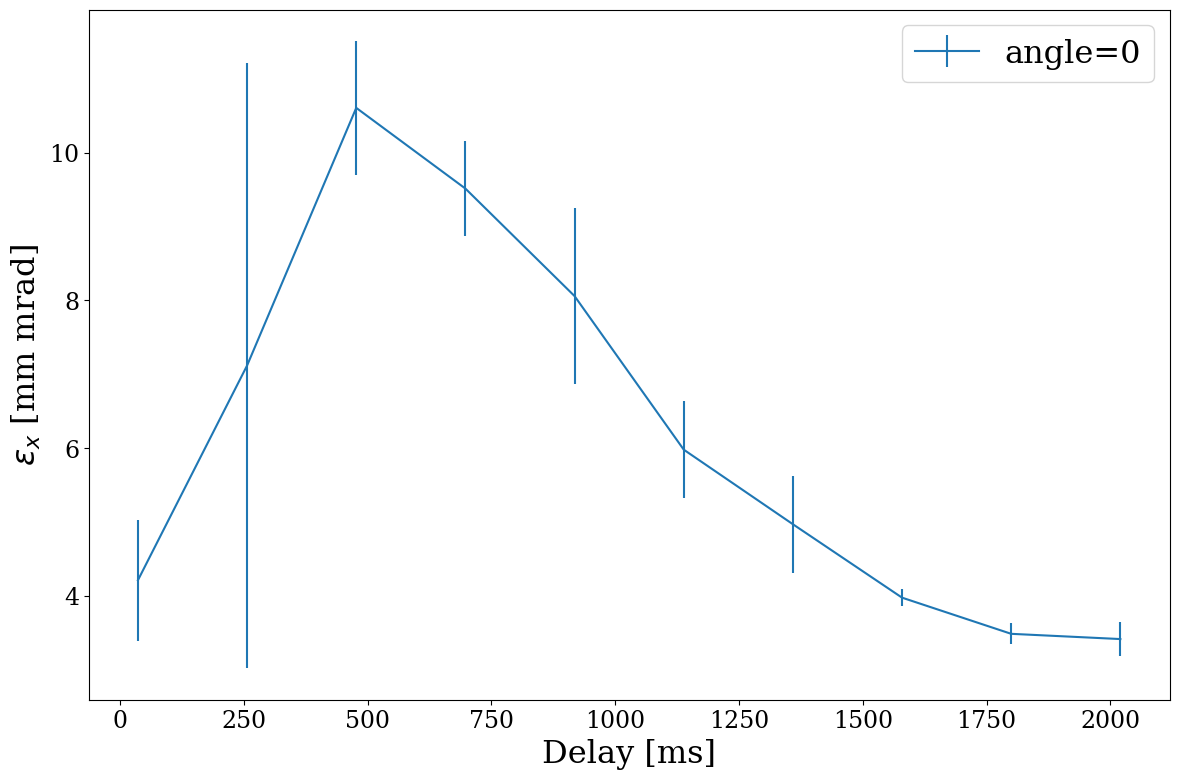

In [2]:
#### Some notes:
'''
Angles and Offsets (of the H- beam) easy/safe to move. 'ELENABEAM/ECOOL-ANGLE-H-mrad'
E_k electrons: at a first order, only need to change  LNR4.ECVCATHLM/REF.DIRECT.V#VALUE
I electrons: need to act, at least, LNR4.ECVGRIDLM/REF.DIRECT.V#VALUE but will probably need to adjust energy as well
-> E_k and I_e are coupled! so you might need to change both at the same time...

The current of the electron, it is in principle measured by LNR4.ECVCOLLM/MEAS.I#VALUE

The current emitted (but not necessarily going into cooling) by the gun, is should be measurable by LNR4.ECVCATHLM/MEAS.I#VALUE

To change the delay of extraction:
AEX.MW-RF/Delay#delay
mind that with 10 ms (10 ticks) delay, you extract approximately at injection

To "not start" the e-cooling process, just set to False
AX.DK3-EC/OutEnable#outEnabled

To delay the start of cooling one can increase the value of
AX.DK3-EC/Delay#delay
Note: the default value=200 1kHz ticks means start at C time 9400, i.e. about 100 ms before our "second injection"


'''



############### Initial imports
# from pyjapcscout import PyJapcScout
from datascout import dict_to_parquet
from datascout import parquet_to_dict
from datascout import unixtime_to_string
import numpy as np
import datascout
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from help_functions import treatBPMData
from help_functions import treatSchottkyData
from help_functions import imagesc
from help_functions import *


data=np.load('H_angles2025/angles.npz')

n_steps=data['n_steps']
num_samples=data['num_samples']
delay_list=data['delay_list']
repeated_delay=data['repeated_delay']
angles_list=data['angles_list']
#horiztonal plane

angles_list=[-3,-2,-1,0,1,2,3]

angles_list = [0]

beta_x = 7.6 #m
beta_y = 1.3 #m

plt.figure(figsize=(12, 8))


for angle_values in angles_list:

    vertical_list = []
    horizontal_list = []

    vertical_integral_list = []
    horizontal_integral_list = []

    for i in range(len(repeated_delay)):
        print('index', i)
        data_to_look_at = parquet_to_dict(f'H_angles2025/angles{angle_values}/{i}.parquet')
        # BPM = data_to_look_at['LNE00.BSGW.0008/Acquisition']['value']
        BPM = data_to_look_at['LNE00.BSGW.0015/Acquisition']['value']
        
        vertical = BPM['sigma'][0]
        horizontal = BPM['sigma'][1]

        vertical_list.append(vertical)
        horizontal_list.append(horizontal)

        vertical_int = BPM['rawIntegrals'][0]
        horizontal_int = BPM['rawIntegrals'][1]

        vertical_integral_list.append(vertical_int)
        horizontal_integral_list.append(horizontal_int)

    filter_threshold_upper = 10
    filter_threshold_lower = 0.05
    integral_threshold = 5000

    filter_horizontal=[]
    filter_horizontal_intensity=[]
    filtered_delay_h=[]

    filter_vertical=[]
    filter_vertical_intensity=[]
    filtered_delay_v=[]

    sigma_x_list=[]

    for i in range(len(horizontal_list)):
        sigma_x=horizontal_list[i]
        sigma_y=vertical_list[i]
        integral_x=horizontal_integral_list[i]
        integral_y=vertical_integral_list[i]
        condition_sigma_x=filter_threshold_lower<sigma_x < filter_threshold_upper
        condition_sigma_y=filter_threshold_lower<sigma_y < filter_threshold_upper
        condition_intensity_x=integral_x > integral_threshold
        condition_intensity_y=integral_y > integral_threshold

        if condition_sigma_x & condition_sigma_y & condition_intensity_x & condition_intensity_y:
            filter_horizontal.append(sigma_x**2/beta_x)
            filter_vertical.append(sigma_y**2/beta_y)
            filter_horizontal_intensity.append(integral_x)
            filter_vertical_intensity.append(integral_y)
            filtered_delay_h.append(repeated_delay[i])
            filtered_delay_v.append(repeated_delay[i])

    diff_h=np.diff(filtered_delay_h)
    diff_v=np.diff(filtered_delay_v)

    indices_h = np.where(diff_h != 0)[0]+1
    indices_v = np.where(diff_v != 0)[0]+1

    sigma_h_groups = np.split(filter_horizontal,indices_h)
    sigma_v_groups = np.split(filter_vertical,indices_v)
    beamsize_h_groups = np.split(sigma_x_list,indices_h)

    h_delay_unique=np.unique(filtered_delay_h)
    v_delay_unique=np.unique(filtered_delay_v)

    means_h=[np.mean(group) for group in  sigma_h_groups]
    means_v=[np.mean(group) for group in sigma_v_groups]

    stds_h=[np.std(group) for group in sigma_h_groups]
    stds_v=[np.std(group) for group in sigma_v_groups]

    #means_sigma=[np.mean(group) for group in  beamsize_h_groups]

    np.savez(f'results2025/angle_x/horizontal/ELENA_angle{angle_values}.npz',
              h_delay_unique=h_delay_unique, means_h=means_h, stds_h=stds_h, angle_values=angle_values)
    np.savez(f'results2025/angle_x/vertical/ELENA_angle{angle_values}.npz',
              v_delay_unique=v_delay_unique, means_v=means_v, stds_v=stds_v, angle_values=angle_values)

    #plt.errorbar(h_delay_unique,means_h,yerr=stds_h,label=f'angle={angle_values}')
    plt.errorbar(v_delay_unique,means_v,yerr=stds_v,label=f'angle={angle_values}')
    plt.xlabel('Delay [ms]')
    plt.ylabel('$\\epsilon_x$ [mm mrad]')
    plt.legend()
    plt.tight_layout()
plt.show()



In [3]:
# Generalized variables
textwidth_cm = 16.50764  # Text width in cm
aspect_ratio = 0.618     # Aspect ratio (height/width) using the golden ratio

# Font sizes
label_fontsize = 12
legend_fontsize = 12
tick_fontsize = 10
colorbar_label_fontsize = 12
colorbar_tick_fontsize = 10
offset_text_fontsize = 12
tick_fontsize = 10
errorbar_capsize = 5

# Convert text width from cm to inches
textwidth_in = textwidth_cm / 2.54

# Calculate figure size based on text width and aspect ratio
fig_width = textwidth_in
fig_height = textwidth_in * aspect_ratio

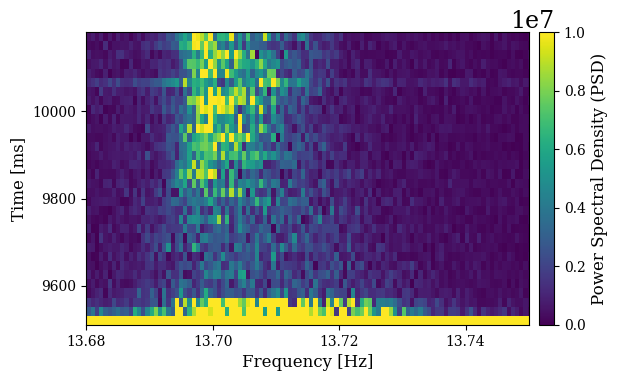

In [ ]:
schottky=data_to_look_at['LNA.BPM/SchottkyAcquisition']['value']
schottky_settings = data_to_look_at['LNA.BPM/SchottkySettings']['value']

schottky_data = treatSchottkyData(schottky,schottky_settings, return_p=True)

psd,time_ms, freq_array=schottky_data

frequencies_Hz=freq_array

plt.figure(figsize=(fig_width, fig_height))
imagesc(psd.transpose(), x=frequencies_Hz, y=time_ms, cmap='viridis')
cbar = plt.colorbar(label='Power Spectral Density (PSD)', pad=0.02)  # Add padding to separate the colorbar
cbar.ax.tick_params(labelsize=colorbar_tick_fontsize)  # Adjust colorbar ticks font size
cbar.set_label('Power Spectral Density (PSD)', fontsize=colorbar_label_fontsize)
plt.xlabel('Momentum [Hz]', fontsize=label_fontsize)
plt.ylabel('Time [ms]', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.xlim((13.68,13.75))
plt.clim([0, 1e7])
# Adjust the format of the tick labels
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()

In [16]:
schottky['schottkyWindow1Spectra'].shape

(32, 2048)

In [17]:
schottky.keys()

dict_keys(['schottkySpectraTimes_ms', 'schottkyWindow1Spectra', 'schottkyWindow1SpectraCount', 'schottkyWindow2Spectra', 'schottkyWindow2SpectraCount'])

In [6]:
schottky_settings['window1FrequencyResolution_hz']

{'JAPC_ENUM': {'code': 1, 'string': 'FRES_48HZ82'}}

In [7]:
freq_array

array([13.02483424, 13.02549812, 13.02616199, ..., 14.38249393,
       14.38315784, 14.38382176])

In [8]:
bin_width = 48.82
time_step = 20.48 + 0.5

settings=schottky_settings
values=schottky

psd = np.copy(values['schottkyWindow1Spectra'])
#psd = np.copy(values['psd'])
number_of_ffts, number_of_fft_bins = np.shape(psd)

_windows_harmonic = int(settings['window1Harmonic']['JAPC_ENUM']['string'][1:])
time_ms = np.arange(settings['window1StartTime_ms'], settings['window1StartTime_ms'] + time_step * number_of_ffts, time_step )
freq_array = np.arange((settings['window1Frev_hz'] * _windows_harmonic) - np.trunc(bin_width * number_of_fft_bins/2),
                            (settings['window1Frev_hz'] * _windows_harmonic) + np.trunc(bin_width * number_of_fft_bins/2),
                                bin_width)

In [9]:
settings['window1Harmonic']['JAPC_ENUM']['string']

'H7'